## Загрузим нужные библиотеки

In [1]:
# Dataframe and Plotting libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss, mean_absolute_error, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import log_loss
from sklearn.linear_model import Ridge
import lightgbm as lgb

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
# from google.colab import files
import warnings
warnings.filterwarnings('ignore')
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import os
#from multiprocessing import Pool
from multiprocess import Pool
from pathlib import Path

from catboost import CatBoostRegressor
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
from functools import partial
from pathlib import Path
import tqdm
from tqdm import tqdm_notebook
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.ensemble import RandomForestClassifier

In [2]:
train = pd.read_csv("train_dataset_train.csv")
test = pd.read_csv("test_dataset_test.csv")

In [3]:
train.shape, test.shape

((6000000, 29), (4000000, 28))

## Рассмотрим датасет поближе

In [4]:
train.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,mailrank,directctg,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629,Участок,7503.0,N,0.0,Y,N,87.0,5.0,1.0,0.0,2.0,0.00,0.0,"Fishhook,USB",41.0,150.0,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0
1,9907176,1023_-1,102976,ММПО,7503.0,N,0.0,N,N,107.0,5.0,1.0,0.0,2.0,0.00,0.0,"screen protector,Case(Q613B),case(208B40-DB)",68.0,400.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0
2,3304275,1018_-1,620962,Цех,7503.0,N,0.0,Y,N,50.0,5.0,1.0,0.0,2.0,0.00,0.0,"Pendant Necklaces,Rings for Women,Necklaces",56.0,218.0,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0
3,9020937,1019_-1,344964,Цех,7503.0,N,0.0,Y,N,416.0,5.0,1.0,0.0,2.0,35.34,0.0,Motorcycle Signal Lamp,33.0,100.0,55.0,2060928.0,653280.0,2714208.0,19562334.0,0,0,0,0,0
4,3082311,1020_-1,629819,Участок,7503.0,N,0.0,Y,N,795.0,5.0,1.0,0.0,2.0,52.52,0.0,backpack,716.0,1000.0,16.0,316919.0,27911.0,344830.0,4719186.0,0,0,0,0,0


In [5]:
def get_df(data_0, mode = 'train'):
    
    #clear data
    data = data_0.copy()
    data['index_oper'] = data['index_oper'].apply(lambda x: -9999 if x ==' ' else float(x)).astype(int)
    data['index_city'] = data['index_oper'].apply(lambda x: str(x)[:3]).astype('int16')
    data['priority'] = data['priority'].astype('int16')
    data['class'] = data['class'].astype('int16')
    data['weight'] = data['weight'].astype(int)
    data['is_wrong_sndr_name'] = data['is_wrong_sndr_name'].astype('int16')
    data['is_wrong_rcpn_name'] = data['is_wrong_rcpn_name'].astype('int16')
    data['is_wrong_phone_number'] = data['is_wrong_phone_number'].astype('int16')
    data['is_wrong_address'] = data['is_wrong_address'].astype('int16')
    data['directctg'] = data['directctg'].astype('int16')
    data['is_return'] = data['is_return'].apply(lambda x: 1 if x == 'Y' else -1 if x == 'N' else 0).astype('int16')
    data['is_in_yandex'] = data['is_in_yandex'].apply(lambda x: 1 if x == 'Y' else -1 if x == 'N' else 0).astype('int16')
    data['is_privatecategory'] = data['is_privatecategory'].apply(lambda x: 1 if x == 'Y' else -1 if x == 'N' else 0).astype('int16')
    data['mailtype'] = data['mailtype'].astype('int16')
    data['postmark'] = data['postmark'].astype('int16')
    data['mailctg'] = data['mailctg'].astype('int16')
    data['weight_mfi'] = data['weight_mfi'].astype('int16')
    data['dist_qty_oper_login_1'] = data['dist_qty_oper_login_1'].astype('int16')
    data['total_qty_oper_login_1'] = data['total_qty_oper_login_1'].astype(int)
    data['total_qty_oper_login_0'] = data['total_qty_oper_login_0'].astype(int)
    data['total_qty_over_index_and_type'] = data['total_qty_over_index_and_type'].astype(int)
    data['total_qty_over_index'] = data['total_qty_over_index'].astype(int)
    data['price_mfi'] = data['price_mfi'].astype(int)
    data['name_mfi'] = data['name_mfi'].str.lower()
    
    data = data.drop(['mailrank'], axis = 1)
    
    
    if mode == 'train':
        data['label'] = data['label'].astype('int16')
        
    #features
    data['name_mfi_is_null'] = data['name_mfi'].apply(lambda x: 1 if x =='0' else 0)
    return data

In [6]:
train = get_df(train)
test = get_df(test, mode = 'test')

In [7]:
train.describe()

,id,index_oper,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,directctg,transport_pay,postmark,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,index_city,name_mfi_is_null
count,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06
mean,4.999167e+06,2.471568e+05,7.499824e+03,-9.986197e-01,3.571923e-01,-1.957637e-01,-9.976723e-01,2.399936e+02,4.995037e+00,7.726733e-01,1.988388e+00,1.187661e+01,9.069800e-02,1.236553e+02,4.560945e+02,3.190689e+02,2.775095e+07,2.898887e+07,5.673982e+07,7.178686e+07,2.564167e-03,2.597737e-01,1.709710e-01,1.262833e-03,2.849667e-02,2.463747e+02,1.359057e-01
std,2.886491e+06,2.048725e+05,1.751917e+02,4.810158e-02,9.861573e-01,9.804243e-01,6.819029e-02,4.504002e+02,1.562659e-01,4.407572e-01,1.073716e-01,2.224794e+01,7.296577e+00,2.084230e+02,2.103291e+03,4.012494e+02,2.903655e+07,5.334262e+07,7.290388e+07,7.509270e+07,5.057264e-02,4.385104e-01,3.764837e-01,3.551392e-02,1.663869e-01,2.049510e+02,3.426884e-01
min,1.000000e+00,-9.999000e+03,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,0.000000e+00
25%,2.500126e+06,1.029760e+05,7.503000e+03,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,5.200000e+01,5.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,5.000000e+01,3.100000e+01,1.113900e+06,1.064800e+04,1.673370e+06,1.040204e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.020000e+02,0.000000e+00
50%,4.999348e+06,1.029980e+05,7.503000e+03,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,1.050000e+02,5.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,6.000000e+01,1.920000e+02,1.130000e+02,9.570832e+06,3.664710e+05,1.393496e+07,5.270807e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.020000e+02,0.000000e+00
75%,7.498348e+06,3.993790e+05,7.506000e+03,-1.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00,2.640000e+02,5.000000e+00,1.000000e+00,2.000000e+00,2.295000e+01,0.000000e+00,1.230000e+02,4.180000e+02,9.140000e+02,5.610820e+07,8.331893e+07,1.321756e+08,1.368198e+08,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.990000e+02,0.000000e+00
max,9.999999e+06,6.949280e+05,7.506000e+03,1.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00,1.580000e+05,9.000000e+00,5.000000e+00,2.000000e+00,8.305000e+02,1.024000e+03,1.800000e+04,1.597050e+05,1.142000e+03,1.416888e+08,4.156581e+08,4.897385e+08,5.002511e+08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.940000e+02,1.000000e+00


In [8]:
test.describe()

,id,index_oper,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,directctg,transport_pay,postmark,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,index_city,name_mfi_is_null
count,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06
mean,5.001248e+06,2.473976e+05,7.499990e+03,-9.986650e-01,3.570955e-01,-1.953740e-01,-9.977215e-01,2.399753e+02,4.995110e+00,7.731600e-01,1.988404e+00,1.187984e+01,9.705500e-02,1.237179e+02,4.556008e+02,3.189355e+02,2.773663e+07,2.897371e+07,5.671034e+07,7.177147e+07,2.582750e-03,2.597957e-01,1.707448e-01,1.236500e-03,2.466156e+02,1.362140e-01
std,2.887142e+06,2.050316e+05,1.716099e+02,4.736263e-02,9.855169e-01,9.805122e-01,6.746710e-02,3.967060e+02,1.554762e-01,4.403370e-01,1.073047e-01,2.224348e+01,7.640904e+00,2.093481e+02,2.115334e+03,4.011988e+02,2.903658e+07,5.333923e+07,7.290373e+07,7.509591e+07,5.075510e-02,4.385225e-01,3.762858e-01,3.514216e-02,2.051105e+02,3.430157e-01
min,0.000000e+00,-9.999000e+03,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,0.000000e+00
25%,2.499771e+06,1.029760e+05,7.503000e+03,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,5.200000e+01,5.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,5.000000e+01,3.100000e+01,1.113748e+06,1.064800e+04,1.656011e+06,1.040204e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.020000e+02,0.000000e+00
50%,5.000941e+06,1.029980e+05,7.503000e+03,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,1.050000e+02,5.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,6.000000e+01,1.920000e+02,1.130000e+02,9.570832e+06,3.664710e+05,1.393496e+07,5.270807e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.020000e+02,0.000000e+00
75%,7.502303e+06,4.000010e+05,7.506000e+03,-1.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00,2.650000e+02,5.000000e+00,1.000000e+00,2.000000e+00,2.291000e+01,0.000000e+00,1.230000e+02,4.190000e+02,9.140000e+02,5.610820e+07,8.331893e+07,1.321756e+08,1.368198e+08,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.000000e+02,0.000000e+00
max,9.999998e+06,6.949280e+05,7.506000e+03,1.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00,1.580000e+05,8.000000e+00,5.000000e+00,2.000000e+00,8.305000e+02,1.024000e+03,1.800000e+04,1.597050e+05,1.142000e+03,1.416888e+08,4.156581e+08,4.897385e+08,5.002511e+08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.940000e+02,1.000000e+00


In [9]:
train.columns

Index(['id', 'oper_type + oper_attr', 'index_oper', 'type', 'priority',
       'is_privatecategory', 'class', 'is_in_yandex', 'is_return', 'weight',
       'mailtype', 'mailctg', 'directctg', 'transport_pay', 'postmark',
       'name_mfi', 'weight_mfi', 'price_mfi', 'dist_qty_oper_login_1',
       'total_qty_oper_login_1', 'total_qty_oper_login_0',
       'total_qty_over_index_and_type', 'total_qty_over_index',
       'is_wrong_sndr_name', 'is_wrong_rcpn_name', 'is_wrong_phone_number',
       'is_wrong_address', 'label', 'index_city', 'name_mfi_is_null'],
      dtype='object')

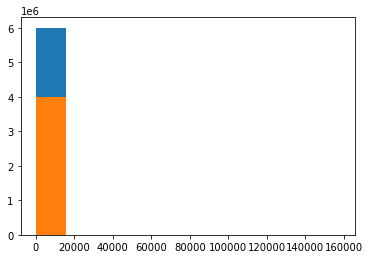

In [10]:
plt.hist(train['weight']);
plt.hist(test['weight']);

## Выделим выборки

Обьединим список не нужных строк с списком строк типа object

In [11]:
col_obj = train.select_dtypes(include=['object']).columns.values
col_obj = list(set(col_obj) ^ set(["id", "label"]))

In [12]:
col_obj

['type', 'label', 'name_mfi', 'id', 'oper_type + oper_attr']

In [28]:
X = train
y = train[["label"]]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение модели

In [15]:
clf = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=32, n_estimators = 500)

In [16]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=32, n_estimators=500, n_jobs=-1,
                       random_state=0)

## Оценка точности

In [17]:
pred = clf.predict_proba(X_test)

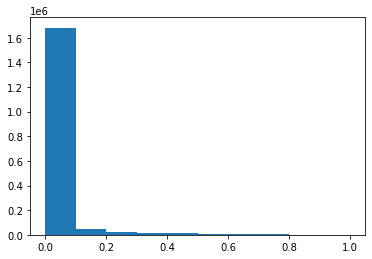

In [18]:
plt.hist(pred[:,1]);

In [19]:
from sklearn.metrics import recall_score

score = recall_score(y_test, np.where(pred[:,1]> 0.028, 1, 0) , average = "macro" )

In [20]:
print("Recall", score)

Recall 0.87594858416423


In [22]:
y_train.mean()

label    0.02848
dtype: float64

In [35]:
# PREDICTION GO

In [30]:
ans = X_test.copy()
ans['pred_rf_proba'] = pred[:,1]

In [36]:
rc_list = []
auc_list = []
for th in tqdm_notebook(range(101)):
    th = th/100
    
    ans['y_pred_rf'] = np.where(ans['pred_rf_proba']>th, 1, 0)
    rc_list.append(recall_score(y_test, ans['y_pred_rf'], zero_division=0, average='macro'))
    auc_list.append(roc_auc_score(y_test, ans['y_pred_rf'], multi_class='ovo'))
    print (roc_auc_score(y_test, ans['y_pred_rf'], multi_class='ovo'))

0.7800783310233131
0.889271045940133
0.8826744397450396
0.8743182096999327
0.865144335868687
0.8558117766890545
0.8471279165330913
0.8393444712649237
0.831899900688372
0.8243309118370619
0.8176808251795417
0.8108157623008183
0.8036651265696555
0.7967506153444384
0.7908248238222284
0.7838874076721754
0.7775745476830082
0.7716359687668052
0.7657321345777648
0.7596886409882834
0.7546166133249612
0.7491578574405775
0.7441581298423701
0.7391412581863455
0.7343462806616681
0.7299171823039942
0.7256273177638417
0.720879976534949
0.7158581042963195
0.7114546494304508
0.7070311301769445
0.7018998103827626
0.6970218622247725
0.6918450783712162
0.6863918107095746
0.6815716163782117
0.6764886510468164
0.6714363175988279
0.6668529836758175
0.6625015395049626
0.6582171022325352
0.6537393889588016
0.6492676437991448
0.6446275479629856
0.6402634859699855
0.6360016621405119
0.6315792445195151
0.6281011165730418
0.6237558111903118
0.6200143403688454
0.6160294935319959
0.6119015194719308
0.60833013933385

In [38]:
rc_list = []
auc_list = []
for th in tqdm_notebook(range(101)):
    th = th/1000
    
    ans['y_pred_rf'] = np.where(ans['pred_rf_proba']>th, 1, 0)
    rc_list.append(recall_score(y_test, ans['y_pred_rf'], zero_division=0, average='macro'))
    auc_list.append(roc_auc_score(y_test, ans['y_pred_rf'], multi_class='ovo'))
    print (th, roc_auc_score(y_test, ans['y_pred_rf'], multi_class='ovo'))

0.0 0.7800783310233131
0.001 0.8572736651066111
0.002 0.8705909561602609
0.003 0.8796336403658455
0.004 0.884482298886606
0.005 0.8867698575133569
0.006 0.8880123822510776
0.007 0.8888346830673249
0.008 0.8894657892372512
0.009 0.8895620947909108
0.01 0.889271045940133
0.011 0.8892172110368064
0.012 0.8887460348666169
0.013 0.8884417741411268
0.014 0.8878491909074246
0.015 0.886950958242642
0.016 0.8859918574675569
0.017 0.8851041379901284
0.018 0.884176971331416
0.019 0.8833223297202815
0.02 0.8826744397450396
0.021 0.8818706163149838
0.022 0.8812907373426513
0.023 0.8803736704793766
0.024 0.8795195708167945
0.025 0.8786377961736364
0.026 0.877596644634897
0.027 0.8766968193574669
0.028 0.8759485841642302
0.029 0.8751334152185866
0.03 0.8743182096999327
0.031 0.8733149116276292
0.032 0.8723657045031239
0.033 0.8713531045950069
0.034 0.8704780893789481
0.035 0.8695900673308343
0.036 0.8687587706228593
0.037 0.8676205588238483
0.038 0.8667570908260337
0.039 0.8659103047301066
0.04 0.865

In [94]:
for v in ans['oper_type + oper_attr'].value_counts().index:
    ans_v = ans[ans['oper_type + oper_attr']==v]
    ans_v['y_pred_rf'] = np.where(ans_v['pred_rf_proba']>0.028, 1, 0)
    print (v, ans_v.shape[0],'SCORE: ', recall_score(ans_v['label'], ans_v['y_pred_rf'], zero_division=0, average='macro'))

1020_-1 207473 SCORE:  0.8908287243088071
1022_-1 197321 SCORE:  0.4757603093436583
1019_-1 124773 SCORE:  0.4003269938207785
8_0 120627 SCORE:  0.4955275352947516
1_-1 107973 SCORE:  0.4951839811804803
1001_-1 105819 SCORE:  0.49905026507527006
1018_-1 95237 SCORE:  0.49922824112477293
1004_-1 92484 SCORE:  0.7693955436701022
1042_-1 87776 SCORE:  0.49958416879329204
1041_-1 86855 SCORE:  0.4995855160900351
1023_-1 63959 SCORE:  0.42555387044825593
8_2 43171 SCORE:  0.15279933288550185
1043_-1 42022 SCORE:  0.7841910202138691
8_6 40510 SCORE:  0.444063194273019
1044_-1 40147 SCORE:  0.49936248406210154
2_1 35767 SCORE:  0.6156139028100863
8_3 34500 SCORE:  0.49943478260869567
1014_-1 31554 SCORE:  0.3329688787475439
1016_-1 22453 SCORE:  0.49986638756513607
11_-1 22288 SCORE:  0.45852027997128497
9_-1 21548 SCORE:  0.45519305736031185
8_13 20995 SCORE:  0.45501309835675163
0_-1 20809 SCORE:  0.46001730020664133
39_-1 17502 SCORE:  0.46537538567020914
185_-1 17361 SCORE:  0.45463970969

In [40]:
col_obj_test = col_obj.copy()
col_obj_test.remove('label')

In [41]:
X_test = test.drop(col_obj_test, axis = 1)

In [42]:
y_pred_test = clf.predict_proba(X_test)

In [43]:
y_pred_test

array([[9.77404174e-01, 2.25958256e-02],
       [8.35130153e-01, 1.64869847e-01],
       [9.99630237e-01, 3.69763370e-04],
       ...,
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [9.99376663e-01, 6.23336718e-04]])

In [44]:
sample_sub = pd.read_csv('sample_solution.csv')

In [45]:
sample_sub['id']

0          7815282
1          8443555
2          6352559
3          4921420
4          1420440
            ...   
3999995    9030800
3999996    6275048
3999997    4701757
3999998     611153
3999999    7776936
Name: id, Length: 4000000, dtype: int64

In [46]:
X_test['pred_proba'] = y_pred_test[:,1]

In [47]:
X_test

,index_oper,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,directctg,transport_pay,postmark,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,index_city,name_mfi_is_null,pred_proba
0,102976,7503,-1,0,-1,-1,85,5,1,2,0.00,0,73,489,972,68766046,91123247,159889293,164927295,0,0,0,0,102,0,0.022596
1,238753,7503,-1,4,1,-1,21,5,0,2,0.00,0,19,186,2,2895,1545,4440,20623,0,1,1,0,238,0,0.164870
2,618254,7503,-1,4,1,-1,388,5,1,2,34.01,0,348,500,3,2751,993,3744,37817,0,0,0,0,618,0,0.000370
3,102968,7503,-1,0,-1,-1,1203,5,1,2,83.72,0,0,0,69,9379609,2267333,11646942,11759329,0,1,0,0,102,1,0.000000
4,102971,7506,-1,0,-1,-1,956,5,1,2,14.95,0,946,1267,181,76138189,8747,76146936,84110459,0,1,0,0,102,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,655003,7503,-1,4,1,-1,53,5,1,2,0.00,0,61,262,3,4297,1803,6100,64613,0,0,0,0,655,0,0.023958
3999996,102976,7503,-1,0,-1,-1,286,5,1,2,32.05,0,0,0,914,48856658,83318932,132175590,136819803,0,1,0,0,102,1,0.009891
3999997,102969,7503,-1,0,-1,-1,733,5,1,2,49.98,0,662,300,106,17348074,3469387,20817461,20821109,0,1,0,0,102,0,0.000000
3999998,104006,7503,-1,0,-1,-1,265,5,1,2,0.00,0,247,500,2,15,13673720,13673735,14041298,0,0,0,0,104,0,0.000000


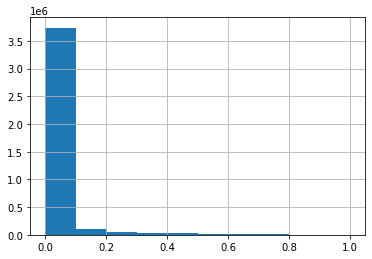

In [48]:
X_test['pred_proba'].hist();

In [49]:
X_test['id']  = test['id'] 
X_test['pred'] = np.where(X_test['pred_proba'] > 0.009, 1, 0)

In [50]:
sample = sample_sub.merge(X_test[['id', 'pred']], how = 'left', on = 'id')

In [51]:
sample['label'] = sample['pred']

In [52]:
sample[['id', 'label']].to_csv('rf_3_again.csv', index=False)